In [68]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('punkt')

# Show all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Checks GPU availability and sets the device to GPU (or CPU)

# Check number of GPUs
num_gpus = torch.cuda.device_count()
print("Number of GPU(s):", num_gpus)

# Check GPU name
if num_gpus > 0:
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU(s): 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Using device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\royle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


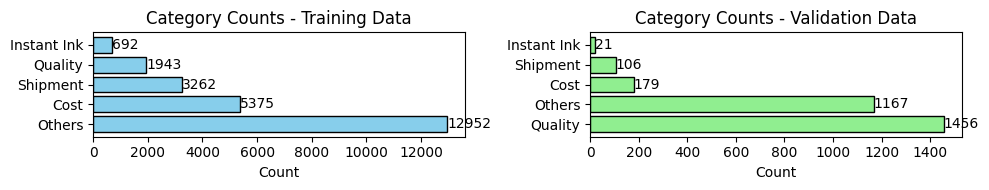

In [69]:
df = pd.read_csv('combined_dfv2.csv', dtype=str)

# 'max_predicted_aspect'  : Ground Truth Aspects / Labels
# 'Combined Text'         : Review Content for Aspect Predictions / Texts

### Data Preparation Steps for Model Training Data
# 1.1 Removal of NaN from Labels and Texts                  ✔️
# 1.2 Renaming of Labels, Product/print Quality -> Quality  ✔️
# 2.1 Creating measure for Token and Sentence Count         ✔️
# 2.2 Filter by Review Length or Tokens                     ✔️
# 3. Filter by Date,  Training: <Apr-24, Validation: Apr-24)✔️

# 1.1 Removal of NaN from Labels and Texts
df = df.dropna(subset=['max_predicted_aspect', 'Combined Text'])

# 1.2 Renaming of Labels, Product/print Quality -> Quality
df['max_predicted_aspect'] = df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})

# 2.1 Creating measure for Token and Sentence Count
def count_tokens(text):
    if isinstance(text, str):  # Only process string values
        return len(text.split())
    return 0  # Return 0 for non-string or NaN values
df['token_count'] = df['Combined Text'].apply(count_tokens)

def count_sentences(text):
    return len(nltk.sent_tokenize(text))
df['sentence_count'] = df['Combined Text'].apply(count_sentences)

# 2.2 Filter by Review Length and/or Tokens
token_threshold = 100
sentence_threshold = 1
df = df[(df['token_count'] <= token_threshold) & (df['sentence_count'] <= sentence_threshold)]

# 3. Filter by Date,  Training: <Apr-24, Validation: Apr-24)
mmm_yy1 = 'Jan-23'
mmm_yy2 = 'Apr-24'
df['date'] = pd.to_datetime(df['Month of Response Date'], format='%b-%y')
cutoff_date1 = pd.to_datetime(mmm_yy1, format='%b-%y')
cutoff_date2 = pd.to_datetime(mmm_yy2, format='%b-%y')

training_df = df[(df['date'] >= cutoff_date1) & (df['date'] < cutoff_date2)].sort_values('date', ascending=False)
validation_df = df[df['date'] == cutoff_date2]
total_df = df


### Plotting bar chart for visual inspection and comparison

# Get value counts for each category in training_df and validation_df
training_value_counts = training_df['max_predicted_aspect'].value_counts()
validation_value_counts = validation_df['max_predicted_aspect'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))

# Plotting the bar chart for training_df
axes[0].barh(training_value_counts.index, training_value_counts.values, color='skyblue', edgecolor='black')
for i in range(len(training_value_counts)):
    axes[0].text(training_value_counts.values[i], i, training_value_counts.values[i], va='center')
axes[0].set_xlabel('Count')
axes[0].set_title('Category Counts - Training Data')

# Plotting the bar chart for validation_df
axes[1].barh(validation_value_counts.index, validation_value_counts.values, color='lightgreen', edgecolor='black')
for i in range(len(validation_value_counts)):
    axes[1].text(validation_value_counts.values[i], i, validation_value_counts.values[i], va='center')
axes[1].set_xlabel('Count')
axes[1].set_title('Category Counts - Validation Data')

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\royle\AppData\Local\Temp\ipykernel_15812\3008654645.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[1, 0].set_xlim(min_sentence_count, max_sentence_count)  # Set x-axis limits
C:\Users\royle\AppData\Local\Temp\ipykernel_15812\3008654645.py:40: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[1, 1].set_xlim(min_sentence_count, max_sentence_count)  # Set x-axis limits


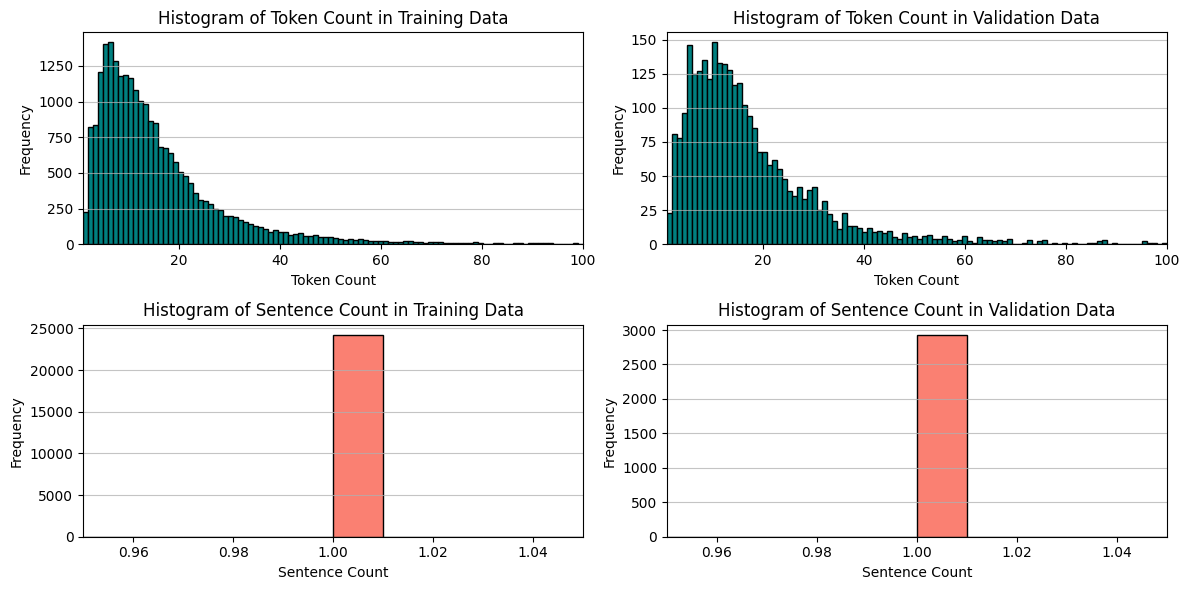

In [70]:
# Create subplots: 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Calculate min and max for token_count and sentence_count
min_token_count = min(training_df['token_count'].min(), validation_df['token_count'].min())
max_token_count = max(training_df['token_count'].max(), validation_df['token_count'].max())

min_sentence_count = min(training_df['sentence_count'].min(), validation_df['sentence_count'].min())
max_sentence_count = max(training_df['sentence_count'].max(), validation_df['sentence_count'].max())

# Plotting the token count histogram for training data
axes[0, 0].hist(training_df['token_count'], bins=100, color='Teal', edgecolor='black')
axes[0, 0].set_xlabel('Token Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram of Token Count in Training Data')
axes[0, 0].set_xlim(min_token_count, max_token_count)  # Set x-axis limits
axes[0, 0].grid(axis='y', alpha=0.75)

# Plotting the sentence count histogram for training data
axes[1, 0].hist(training_df['sentence_count'], bins=100, color='Salmon', edgecolor='black')
axes[1, 0].set_xlabel('Sentence Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of Sentence Count in Training Data')
axes[1, 0].set_xlim(min_sentence_count, max_sentence_count)  # Set x-axis limits
axes[1, 0].grid(axis='y', alpha=0.75)

# Plotting the token count histogram for validation data
axes[0, 1].hist(validation_df['token_count'], bins=100, color='Teal', edgecolor='black')
axes[0, 1].set_xlabel('Token Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Token Count in Validation Data')
axes[0, 1].set_xlim(min_token_count, max_token_count)  # Set x-axis limits
axes[0, 1].grid(axis='y', alpha=0.75)

# Plotting the sentence count histogram for validation data
axes[1, 1].hist(validation_df['sentence_count'], bins=100, color='Salmon', edgecolor='black')
axes[1, 1].set_xlabel('Sentence Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of Sentence Count in Validation Data')
axes[1, 1].set_xlim(min_sentence_count, max_sentence_count)  # Set x-axis limits
axes[1, 1].grid(axis='y', alpha=0.75)

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\royle\AppData\Local\Temp\ipykernel_15812\824700589.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = (training_df.groupby('max_predicted_aspect').apply(lambda x: x.head(n=min(len(x), n_sample))).reset_index(drop=True))                      #most recent


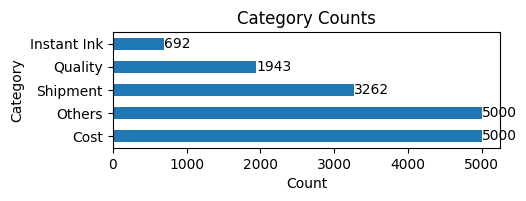

In [71]:
# sample equal no. of records from each label
n_sample = 5000
# sampled_df = (training_df.groupby('max_predicted_aspect').apply(lambda x: x.sample(n=min(len(x), n_sample), random_state=93)).reset_index(drop=True))   #random sampling
sampled_df = (training_df.groupby('max_predicted_aspect').apply(lambda x: x.head(n=min(len(x), n_sample))).reset_index(drop=True))                      #most recent 

value_counts = sampled_df['max_predicted_aspect'].value_counts()

# horizontal bar chart plot
plt.figure(figsize=(5, 1.5))
ax = value_counts.plot(kind='barh')
for i in ax.containers:
    ax.bar_label(i)

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Counts')
plt.show()

In [72]:
### Select training dataset
# training_df
# sampled_df
# total_df
df = total_df

# 'max_predicted_aspect'  : Ground Truth Aspects / Labels
# 'Combined Text'         : Review Content for Aspect Predictions / Texts

data_texts = df['Combined Text'].to_list()                  # Texts 

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data_labels = df['max_predicted_aspect'].to_list()          # Original labels
data_labels = label_encoder.fit_transform(data_labels)      # Numeric labels

# Get the mapping of original labels to numeric labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print(label_mapping)
print(label_encoder.classes_.tolist())

# {'Cost': 0, 'Instant Ink': 1, 'Others': 2, 'Quality': 3, 'Shipment': 4}
# ['Cost', 'Instant Ink', 'Others', 'Quality', 'Shipment']

{'Cost': 0, 'Instant Ink': 1, 'Others': 2, 'Quality': 3, 'Shipment': 4}
['Cost', 'Instant Ink', 'Others', 'Quality', 'Shipment']


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\train

  0%|          | 0/1017 [00:00<?, ?it/s]

{'loss': 1.3768, 'grad_norm': 2.0344598293304443, 'learning_rate': 1e-05, 'epoch': 0.29}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.1222500801086426, 'eval_accuracy': 0.6271404897808875, 'eval_precision': 0.47173196523824706, 'eval_recall': 0.6271404897808875, 'eval_f1': 0.5220026003023779, 'eval_runtime': 14.1492, 'eval_samples_per_second': 383.839, 'eval_steps_per_second': 24.03, 'epoch': 0.29}
{'loss': 1.0969, 'grad_norm': 2.4567174911499023, 'learning_rate': 2e-05, 'epoch': 0.59}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0634146928787231, 'eval_accuracy': 0.626403977168109, 'eval_precision': 0.4729992344967954, 'eval_recall': 0.626403977168109, 'eval_f1': 0.5210106305817459, 'eval_runtime': 14.0992, 'eval_samples_per_second': 385.2, 'eval_steps_per_second': 24.115, 'epoch': 0.59}
{'loss': 1.0336, 'grad_norm': 1.8806612491607666, 'learning_rate': 3e-05, 'epoch': 0.88}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9909173846244812, 'eval_accuracy': 0.6346897440618671, 'eval_precision': 0.5684517346561957, 'eval_recall': 0.6346897440618671, 'eval_f1': 0.5739518742617261, 'eval_runtime': 14.1142, 'eval_samples_per_second': 384.79, 'eval_steps_per_second': 24.089, 'epoch': 0.88}
{'loss': 0.9802, 'grad_norm': 1.7289108037948608, 'learning_rate': 4e-05, 'epoch': 1.18}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9742714166641235, 'eval_accuracy': 0.6383723071257595, 'eval_precision': 0.5667259722344639, 'eval_recall': 0.6383723071257595, 'eval_f1': 0.5797190712055545, 'eval_runtime': 14.1475, 'eval_samples_per_second': 383.883, 'eval_steps_per_second': 24.032, 'epoch': 1.18}
{'loss': 0.9515, 'grad_norm': 1.8538477420806885, 'learning_rate': 5e-05, 'epoch': 1.47}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9801293611526489, 'eval_accuracy': 0.6387405634321488, 'eval_precision': 0.5635220126287658, 'eval_recall': 0.6387405634321488, 'eval_f1': 0.5623306485128577, 'eval_runtime': 14.0974, 'eval_samples_per_second': 385.249, 'eval_steps_per_second': 24.118, 'epoch': 1.47}
{'loss': 0.9474, 'grad_norm': 1.6685305833816528, 'learning_rate': 4.032882011605416e-05, 'epoch': 1.77}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9690191745758057, 'eval_accuracy': 0.6402135886577057, 'eval_precision': 0.5733508264253913, 'eval_recall': 0.6402135886577057, 'eval_f1': 0.585272738739643, 'eval_runtime': 14.1395, 'eval_samples_per_second': 384.102, 'eval_steps_per_second': 24.046, 'epoch': 1.77}
{'loss': 0.9519, 'grad_norm': 1.7640209197998047, 'learning_rate': 3.065764023210832e-05, 'epoch': 2.06}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9587463140487671, 'eval_accuracy': 0.6455533051003498, 'eval_precision': 0.5775621662880488, 'eval_recall': 0.6455533051003498, 'eval_f1': 0.5798583857616442, 'eval_runtime': 13.9932, 'eval_samples_per_second': 388.118, 'eval_steps_per_second': 24.298, 'epoch': 2.06}
{'loss': 0.8759, 'grad_norm': 2.911787748336792, 'learning_rate': 2.0986460348162475e-05, 'epoch': 2.36}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9755226373672485, 'eval_accuracy': 0.6481310992450746, 'eval_precision': 0.5829787645497254, 'eval_recall': 0.6481310992450746, 'eval_f1': 0.5865778908268338, 'eval_runtime': 14.0467, 'eval_samples_per_second': 386.638, 'eval_steps_per_second': 24.205, 'epoch': 2.36}
{'loss': 0.8861, 'grad_norm': 2.7832107543945312, 'learning_rate': 1.1315280464216636e-05, 'epoch': 2.65}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9683899879455566, 'eval_accuracy': 0.6461056895599337, 'eval_precision': 0.5816434248530647, 'eval_recall': 0.6461056895599337, 'eval_f1': 0.5893920292642361, 'eval_runtime': 14.1879, 'eval_samples_per_second': 382.791, 'eval_steps_per_second': 23.964, 'epoch': 2.65}
{'loss': 0.8731, 'grad_norm': 2.6430647373199463, 'learning_rate': 1.644100580270793e-06, 'epoch': 2.95}


  0%|          | 0/340 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9678151607513428, 'eval_accuracy': 0.6431596391088198, 'eval_precision': 0.5751376823505103, 'eval_recall': 0.6431596391088198, 'eval_f1': 0.5895908072875893, 'eval_runtime': 14.0229, 'eval_samples_per_second': 387.294, 'eval_steps_per_second': 24.246, 'epoch': 2.95}
{'train_runtime': 697.6264, 'train_samples_per_second': 93.411, 'train_steps_per_second': 1.458, 'train_loss': 0.9951805294790802, 'epoch': 3.0}


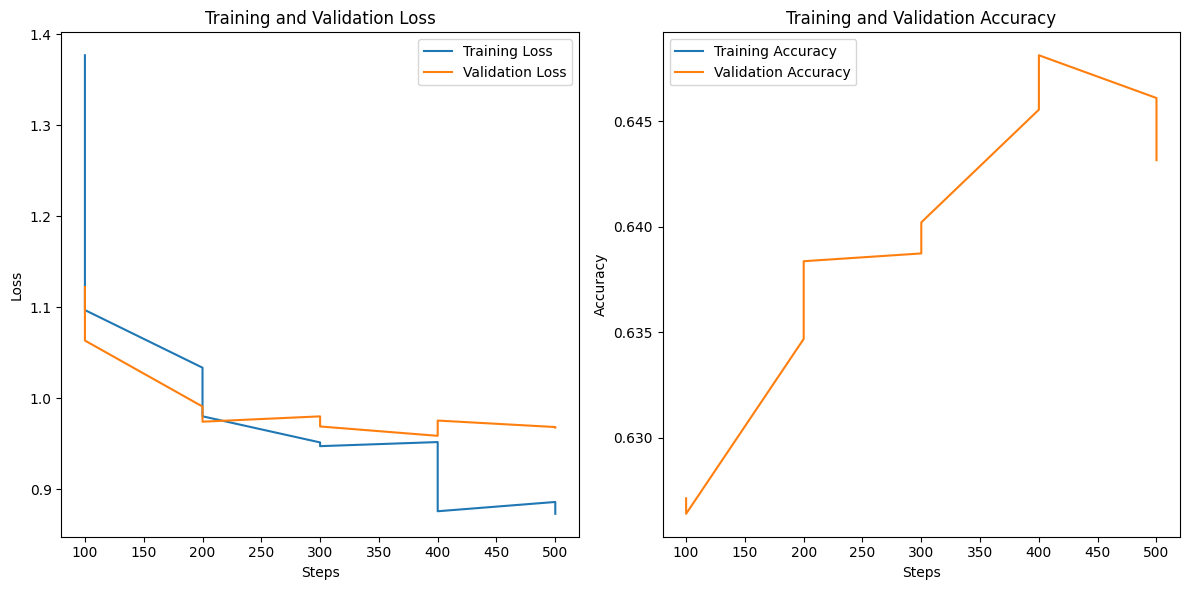

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)

# Create a PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',  # Use 'max_length' to ensure all sequences have the same length
            max_length=max_length,
            return_tensors='pt'  # Return PyTorch tensors
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # Get item from encodings
        item['labels'] = torch.tensor(self.labels[idx])  # Convert labels to tensor
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Set device
if torch.cuda.is_available():
    model.cuda()

# Define compute_metrics function to calculate accuracy, precision, recall, and f1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results', 
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="steps",
    save_strategy="steps",  
    save_steps=100,  
    load_best_model_at_end=True,
    eval_steps=100,  
    logging_steps=100,  
    metric_for_best_model='f1',  
    greater_is_better=True,  
    gradient_accumulation_steps=4,
    fp16=True
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
train_result = trainer.train()

# Save training history
metrics = train_result.metrics
# Save the model, tokenizer, and training arguments to the output directory
model.save_pretrained('models/distilbert aspect classification 101024 (trained before Apr-24) 1 sentence')
tokenizer.save_pretrained('models/distilbert aspect classification 101024 (trained before Apr-24) 1 sentence')

# Retrieve the training logs for plotting
logs = trainer.state.log_history

# Extract losses and accuracies for plotting
train_loss = [log['loss'] for log in logs if 'loss' in log and 'step' in log]
val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log and 'step' in log]
train_accuracy = [log['accuracy'] for log in logs if 'accuracy' in log and 'step' in log]
val_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log and 'step' in log]
steps = [log['step'] for log in logs if 'step' in log]

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(steps[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(steps[:len(val_loss)], val_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(steps[:len(train_accuracy)], train_accuracy, label='Training Accuracy')
plt.plot(steps[:len(val_accuracy)], val_accuracy, label='Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


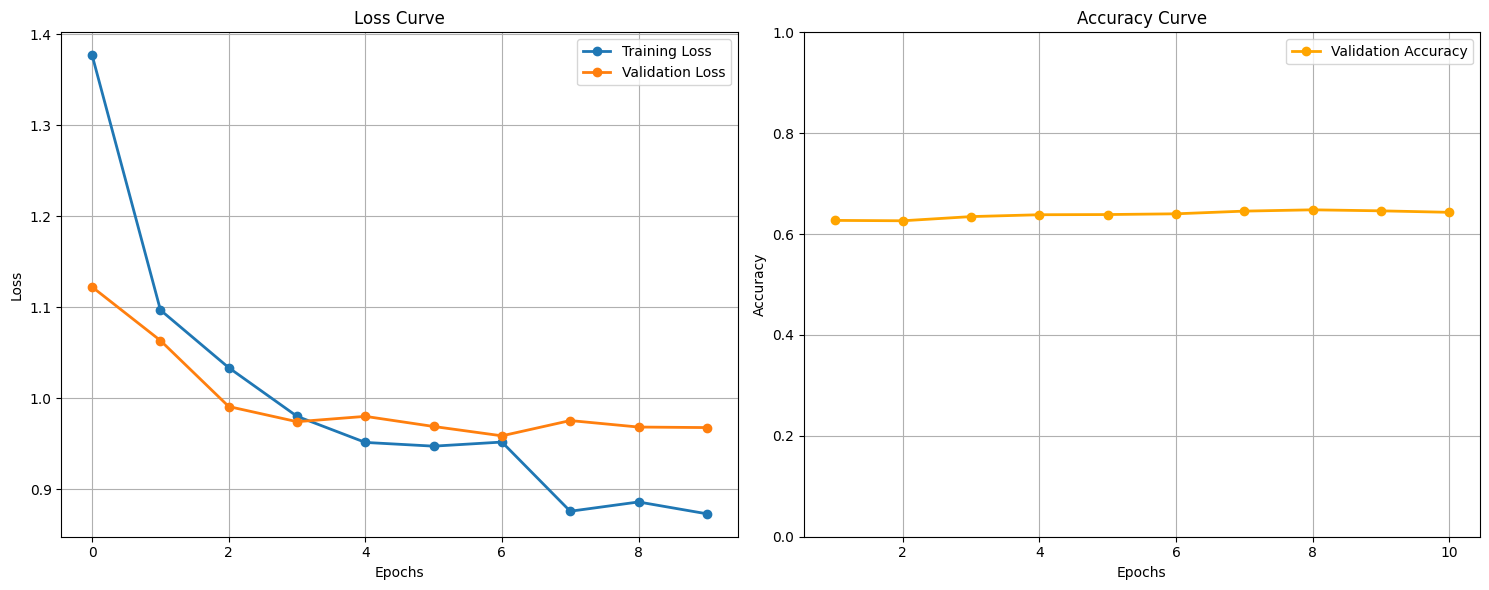

In [84]:
def plot_training_curves(trainer):
    # Access the logs
    logs = trainer.state.log_history

    train_loss = [log['loss'] for log in logs if 'loss' in log and 'step' in log]
    val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log and 'step' in log]
    train_accuracy = [log['accuracy'] for log in logs if 'accuracy' in log and 'step' in log]
    val_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log and 'step' in log]
    steps = [log['step'] for log in logs if 'step' in log]

    # Define the epochs (x-axis values)
    epochs = range(1, len(val_accuracy) + 1)  # Ensure the x-axis matches the number of epochs

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Change to 1 row and 2 columns

    # Plot loss
    axs[0].plot(train_loss, label='Training Loss', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[0].plot(val_loss, label='Validation Loss', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot accuracy
    # axs[1].plot(epochs, train_accuracy, label='Training Accuracy', color='blue', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[1].plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[1].set_title('Accuracy Curve')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1) 
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(trainer)


In [77]:
model_paths = {
    'model_1': 'models/distilbert aspect classification 081024 (trained on Apr-24)',
    'model_2': 'models/distilbert aspect classification 081024 (trained on Apr-24 v2)',
    'model_3': 'models/distilbert aspect classification 101024 (trained before Apr-24) 2 sentence',
    'model_4': 'models/distilbert aspect classification 101024 (trained before Apr-24) 1 sentence'
}

aspect_labels = ['Cost', 'Instant Ink', 'Others', 'Quality', 'Shipment']

label_encoder.fit(aspect_labels)

# Load tokenizer and models
tokenizers = {}
models = {}

for model_key, model_path in model_paths.items():
    tokenizers[model_key] = DistilBertTokenizer.from_pretrained(model_path)
    models[model_key] = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=5)

    # Move model to GPU if available
    if torch.cuda.is_available():
        models[model_key].cuda()

def get_predictions(model, tokenizer, texts):
    predictions = []
    
    for text in texts:
        # Tokenize the input sentence
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Model inference (prediction)
        with torch.no_grad():
            outputs = model(**inputs)  # No 'return_tensors' needed here
            logits = outputs.logits

        # Get predicted label
        pred_label = torch.argmax(logits, dim=1).item()
        # Convert predicted label back to category
        predicted_category = label_encoder.inverse_transform([pred_label])[0]
        predictions.append(predicted_category)

    return predictions


test_sentences = [
    "I am happy with the quality.",
    "Great ink quality",
    "Excellent customer service!",
    "Expensive but good",
    "The packaging was damaged.",
    "Worth the money",
    "Great value for the price, I saved a lot compared to buying cartridges in stores.",
    "The Instant Ink service is convenient, but sometimes the ink arrives a little later than expected.",
    "The customer service team was really helpful when I had issues with my account.",
    "The print quality is sharp and vibrant, especially for photos and color documents.",
    "My shipment arrived faster than anticipated, well-packaged and in perfect condition.",
    "While the ink is affordable, I feel like I go through cartridges quicker than expected.",
    "I love how Instant Ink automatically ships new cartridges when I'm running low.",
    "The app is easy to use, but I wish it had more detailed tracking options for ink usage.",
    "The ink delivers consistent quality across different types of paper, even on glossy finishes.",
    "Delivery was on time, but it would be great to have an express shipping option for emergencies."
]

results_df = pd.DataFrame(test_sentences, columns=['Sentence'])

# Prepare to store predictions
for model_key in model_paths.keys():
    # Get predictions for the current model
    predictions = get_predictions(models[model_key], tokenizers[model_key], results_df['Sentence'].tolist())
    
    # Add predictions to the DataFrame
    results_df[f'{model_key}_predictions'] = predictions

results_df

,Sentence,model_1_predictions,model_2_predictions,model_3_predictions,model_4_predictions
0,I am happy with the quality.,Others,Others,Others,Others
1,Great ink quality,Quality,Quality,Others,Others
2,Excellent customer service!,Others,Others,Others,Others
3,Expensive but good,Cost,Cost,Others,Others
4,The packaging was damaged.,Others,Quality,Others,Others
5,Worth the money,Others,Others,Others,Others
6,"Great value for the price, I saved a lot compared to buying cartridges in stores.",Cost,Cost,Others,Others
7,"The Instant Ink service is convenient, but sometimes the ink arrives a little later than expected.",Quality,Quality,Instant Ink,Instant Ink
8,The customer service team was really helpful when I had issues with my account.,Others,Others,Others,Others
9,"The print quality is sharp and vibrant, especially for photos and color documents.",Quality,Quality,Others,Others


In [78]:
model_paths = {
    'model_1': 'models/distilbert aspect classification 081024 (trained on Apr-24)',
    'model_2': 'models/distilbert aspect classification 081024 (trained on Apr-24 v2)',
    'model_3': 'models/distilbert aspect classification 101024 (trained before Apr-24) 2 sentence',
    'model_4': 'models/distilbert aspect classification 101024 (trained before Apr-24) 1 sentence'
}

aspect_labels = ['Cost', 'Instant Ink', 'Others', 'Quality', 'Shipment']

label_encoder.fit(aspect_labels)

# Load tokenizer and models
tokenizers = {}
models = {}

for model_key, model_path in model_paths.items():
    tokenizers[model_key] = DistilBertTokenizer.from_pretrained(model_path)
    models[model_key] = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=5)

    # Move model to GPU if available
    if torch.cuda.is_available():
        models[model_key].cuda()

def get_predictions(model, tokenizer, texts):
    predictions = []
    
    for text in texts:
        # Tokenize the input sentence
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Model inference (prediction)
        with torch.no_grad():
            outputs = model(**inputs)  # No 'return_tensors' needed here
            logits = outputs.logits

        # Get predicted label
        pred_label = torch.argmax(logits, dim=1).item()
        # Convert predicted label back to category
        predicted_category = label_encoder.inverse_transform([pred_label])[0]
        predictions.append(predicted_category)

    return predictions

# Prepare to store predictions
for model_key in model_paths.keys():
    # Get predictions for the current model
    predictions = get_predictions(models[model_key], tokenizers[model_key], validation_df['Combined Text'].tolist())
    
    # Add predictions to the DataFrame
    validation_df[f'{model_key}_predictions'] = predictions

validation_df.head(3)

C:\Users\royle\AppData\Local\Temp\ipykernel_15812\3099844015.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df[f'{model_key}_predictions'] = predictions
C:\Users\royle\AppData\Local\Temp\ipykernel_15812\3099844015.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df[f'{model_key}_predictions'] = predictions
C:\Users\royle\AppData\Local\Temp\ipykernel_15812\3099844015.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,Printer Family,Model Name,Combined Text,Ink Supply Type,token_count,Month of Response Date,predicted_level1,predicted_probabilities,max_predicted_probability,max_predicted_level1,max_predicted_aspect,sentence_count,date,model_1_predictions,model_2_predictions,model_3_predictions,model_4_predictions
18,110020182,HP 63 Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,NaN,HP 63 Black Original Ink Cartridge,"Excllent quality; easy to order, received promptly.",IPH,7,Apr-24,"Logistic Handling, General satisfied","['0.8352197918762199', '0.7786848755893012']",0.880666667,Brand Loyalty,Others,1,2024-04-01,Others,Others,Shipment,Shipment
108,123460320,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,NaN,HP 65XL Black Original Ink Cartridge,Great price and arrived even earlier than stated.,IPH,8,Apr-24,Logistic Handling,['0.7908739113381595'],0.796588235,Brand Loyalty,Others,1,2024-04-01,Others,Others,Shipment,Shipment
259,156247650,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,NaN,HP 65XL Black Original Ink Cartridge,The item was what I was looking for and I love the walmart service,IPH,14,Apr-24,Others,['0'],0.824666667,Brand Loyalty,Others,1,2024-04-01,Others,Others,Others,Others


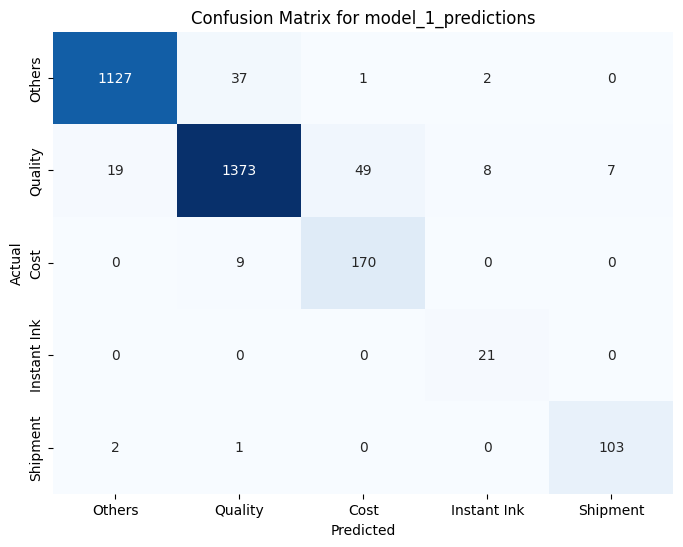


Metrics Summary per Category for model_1_predictions:
      Category  Accuracy  Precision    Recall
0       Others  0.965724   0.981707  0.965724
1      Quality  0.942995   0.966901  0.942995
2         Cost  0.949721   0.772727  0.949721
3  Instant Ink  1.000000   0.677419  1.000000
4     Shipment  0.971698   0.936364  0.971698


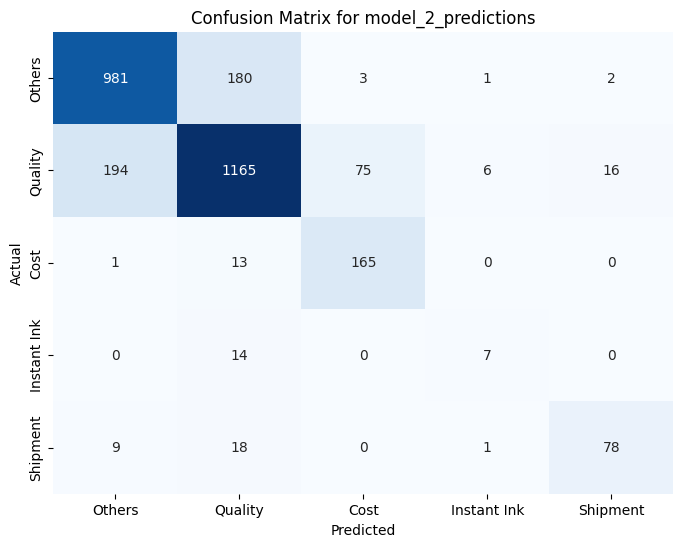


Metrics Summary per Category for model_2_predictions:
      Category  Accuracy  Precision    Recall
0       Others  0.840617   0.827848  0.840617
1      Quality  0.800137   0.838129  0.800137
2         Cost  0.921788   0.679012  0.921788
3  Instant Ink  0.333333   0.466667  0.333333
4     Shipment  0.735849   0.812500  0.735849


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


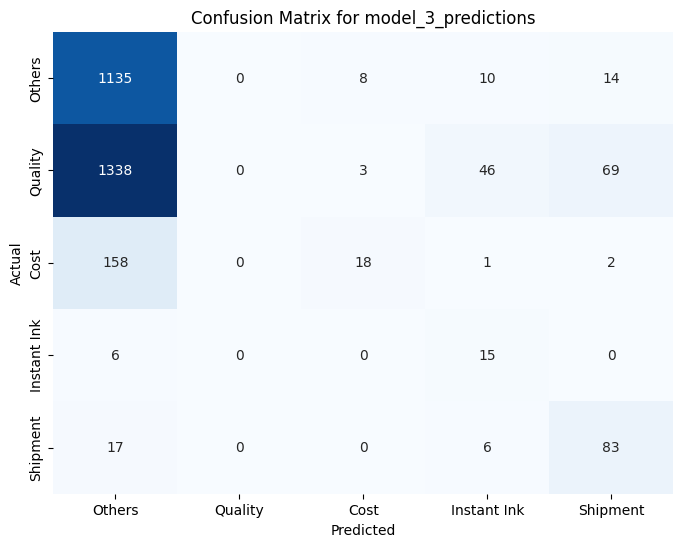


Metrics Summary per Category for model_3_predictions:
      Category  Accuracy  Precision    Recall
0       Others  0.972579   0.427656  0.972579
1      Quality  0.000000   0.000000  0.000000
2         Cost  0.100559   0.620690  0.100559
3  Instant Ink  0.714286   0.192308  0.714286
4     Shipment  0.783019   0.494048  0.783019


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


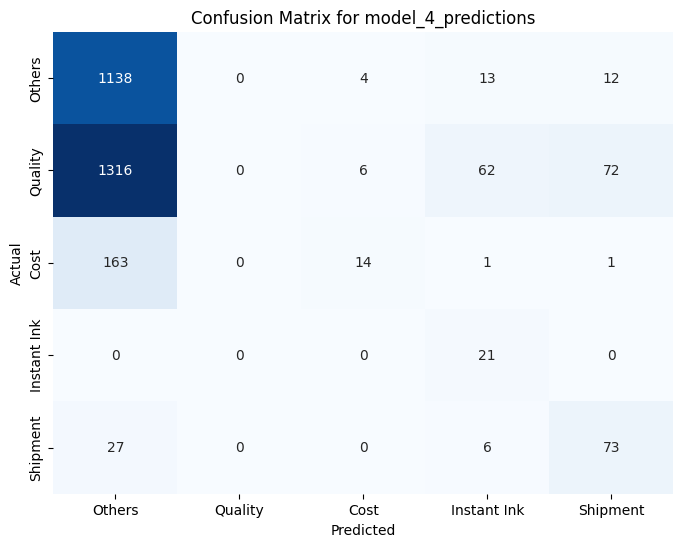


Metrics Summary per Category for model_4_predictions:
      Category  Accuracy  Precision    Recall
0       Others  0.975150   0.430408  0.975150
1      Quality  0.000000   0.000000  0.000000
2         Cost  0.078212   0.583333  0.078212
3  Instant Ink  1.000000   0.203883  1.000000
4     Shipment  0.688679   0.462025  0.688679


In [80]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, categories, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Categories
categories = validation_df['max_predicted_aspect'].unique()

prediction_columns = [col for col in validation_df.columns if col.endswith('_predictions')]

# Loop through each model's predictions and plot confusion matrices
for model_col in prediction_columns:
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(validation_df['max_predicted_aspect'], validation_df[model_col], labels=categories)
    
    # Calculate accuracy per category
    accuracy_per_category = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
    
    # Calculate precision, recall, and f1-score per category
    precision, recall, _, _ = precision_recall_fscore_support(
        validation_df['max_predicted_aspect'], 
        validation_df[model_col], 
        labels=categories, 
        average=None  # This calculates per-category metrics
    )

    # Plot the confusion matrix
    plot_confusion_matrix(conf_matrix, categories, title=f'Confusion Matrix for {model_col}')

    # Create a DataFrame to show accuracies, precision, and recall per category
    metrics_summary_df = pd.DataFrame({
        'Category': categories,
        'Accuracy': accuracy_per_category,
        'Precision': precision,
        'Recall': recall
    })

    # Print the accuracy, precision, and recall summary DataFrame
    print(f"\nMetrics Summary per Category for {model_col}:")
    print(metrics_summary_df)

In [92]:
# 'Cost', 'Instant Ink', 'Others', 'Quality', 'Shipment'
Actual = 'Quality'
Predicted = 'Others'

pd.set_option('display.max_colwidth', None)  # Display full content of each cell
validation_df[(validation_df['max_predicted_aspect'] == Actual) & (validation_df['model_3_predictions'] == Predicted)][['Combined Text', 'max_predicted_aspect', 'model_3_predictions']].reset_index(drop=True).iloc[10:15]


,Combined Text,max_predicted_aspect,model_3_predictions
10,Good product but not convinced by the instant ink program,Quality,Others
11,Because of instant ink,Quality,Others
12,I like the instant ink plan,Quality,Others
13,Company reputation saved by instant ink associate who was awesome.,Quality,Others
14,I had problem with the enclosed ink cartridge.,Quality,Others


In [95]:
sampled_df[(sampled_df['max_predicted_aspect'] == Actual)][['Combined Text', 'max_predicted_aspect']].reset_index(drop=True).iloc[10:25]

,Combined Text,max_predicted_aspect
10,Very informative when there's a problem \r\nAlways on time with replacement inks,Quality
11,"Because it is very economical in ink and energy, but sometimes it happens that it pulls more sheets than ideal and loses the print.",Quality
12,I didn't understand the concept I pay but I receive nothing\r\n Neither leaves nor ink,Quality
13,"The printer is great and easy to access, only the cartridges aren't that cheap, which is great",Quality
14,It ran out of ink so fast,Quality
15,Always missing ink,Quality
16,I never run out of ink or paper and the service is good.,Quality
17,"Because it is a good printer, cartridges with good capacity and the financial cost of the cartridges is very good.",Quality
18,"Ease of use, great reliability and peace of mind in receiving the cartridges at home",Quality
19,"Not even so much ink when printing and its printing is of good quality, only the scanning takes a little while",Quality
